## Introduction

Je me suis amusé à créer une petite simulation d'un circuit d'autobus.  Par manque de données réelles, j'ai fait plusieurs suppositions et j'ai aussi simplifié grandement le problème.  L'objectif est de déterminer la fréquence optimale de passage des autobus sur un circuit donné.

## Hypothèses

On considère un circuit linéaire, c'est-à-dire qu'il y a un *premier* et un *dernier* arrêt.  Un autobus arrive vide au premier arrêt à une fréquence constante (par exemple, un autobus toutes les 20 minutes).  À chaque arrêt, sauf au premier, des passagers entrent dans l'autobus et des passagers en sortent.  Au dernier arrêt, aucun passager n'entre et tous les passagers doivent descendre.  Advenant le cas où tous les passagers présents à un arrêt ne puissent pas monter dans l'autobus parce qu'il est plein, les passagers qui montent à bord sont choisis selon le principe du premier arrivé, premier servi.  Autrement dit, les passagers attendent l'autobus dans une queue de type *first in first out* (FIFO).

On suppose que la distance entre deux arrêts successifs et la vitesse des autobus entre deux arrêts sont constantes.

À chaque arrêt, les passagers arrivent suivant un processus de Poisson de paramètre $\lambda$.  La destination d'un passager est choisie au hasard en ajoutant un à une variable normale de moyenne positive $\mu$ et d'écart-type $\sigma$ tronquée à zéro.  L'ajout du 1 est nécessaire pour tenir compte du fait qu'un passager veut au moins se rendre au prochain arrêt.

Les coûts d'opération pour qu'un autobus parcourt le circuit sont de 500<span>$</span>.  Le coût d'un billet d'autobus pour un passager, indépendamment de la distance parcourue, est de 2<span>$</span>.  Pour être rentable, chaque autobus doit donc transporter au moins 250 passagers par circuit.  Si la rentabilité était le seul facteur, la stratégie optimale serait obtenue en maximisant le nombre de passagers désservis.  Pour cela, il faudrait que la fréquence soit suffisamment petite pour que les autobus soient presque toujours pleins, mais suffisamment grande pour que le nombre total de passagers déplacés soit élevé. 

Si cette stratégie est adoptée, les files d'attente à chaque arrêt seront probablement très longues et le temps de service pour chaque passager sera probablement très long.  Les passagers seront mécontent et délaisseront le transport en commun au profit de leur voiture, résultant en une baisse de profitabilité à long terme.  Une stratégie intelligente doit donc tenir compte à la fois de la rentabilité de chaque autobus, mais aussi de la satisfaction de la clientèle.

Un client sera mécontent s'il doit attendre l'autobus longtemps.  Une fois qu'il est dans l'autobus, on suppose que la durée du trajet n'influence pas son appréciation du service.  Supposons que la satisfaction d'un client, sur une échelle de 0 (très insatisfait) à 1 (très satisfait), soit donnée par

$$S(t) = \frac{1}{2} \left(1 - \tanh\left(\frac{1}{10}(t - \gamma )\right)\right).$$

Par exemple, pour $\gamma = 30$ minutes, la fonction de satisfaction ressemble à ceci.

In [3]:
import matplotlib as mpl

class PrettyFig(mpl.figure.Figure):
    def add_subplot(self, *args, **kwargs):
        ax = super(PrettyFig, self).add_subplot(*args, **kwargs)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.grid(axis='y')
        for loc, spine in ax.spines.items():
            if loc in ['left','bottom']:
                spine.set_position(('outward',8)) # outward by 10 points
            elif loc in ['right','top']:
                spine.set_color('none') # don't draw spine
            else:
                raise ValueError('unknown spine location: %s'%loc)
        return ax

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the multiarray numpy extension module failed.  Most
likely you are trying to import a failed build of numpy.
Here is how to proceed:
- If you're working with a numpy git repository, try `git clean -xdf`
  (removes all files not under version control) and rebuild numpy.
- If you are simply trying to use the numpy version that you have installed:
  your installation is broken - please reinstall numpy.
- If you have already reinstalled and that did not fix the problem, then:
  1. Check that you are using the Python you expect (you're using C:\Users\W10\.conda\envs\chooseAnotherName\python.exe),
     and that you have no directories in your PATH or PYTHONPATH that can
     interfere with the Python and numpy versions you're trying to use.
  2. If (1) looks fine, you can open a new issue at
     https://github.com/numpy/numpy/issues.  Please include details on:
     - how you installed Python
     - how you installed numpy
     - your operating system
     - whether or not you have multiple versions of Python installed
     - if you built from source, your compiler versions and ideally a build log

     Note: this error has many possible causes, so please don't comment on
     an existing issue about this - open a new one instead.

Original error was: DLL load failed: A dynamic link library (DLL) initialization routine failed.


In [ ]:
import numpy as np

x = np.linspace(0, 60, 500)
y = 0.5 * (1 - np.tanh(0.1*(x - 30)))
fig = figure(FigureClass=PrettyFig)
plot(x, y, linewidth=2)
xlabel("Temps d'attente (min)")
ylabel("Satisfaction")

L'objectif est de maximiser les profits tout en maximisant la satisfaction des consommateurs.  On définit la fonction objectif comme une moyenne pondérée de ces deux éléments.  La poids accordé aux profits est $\alpha$ et le poids accordé à la satisfaction des consommateurs est $1 - \alpha$.  Si on ne tient compte que du profit moyen $\bar{P}$ et de la satisfaction moyenne $\bar{S}$, la fonction objectif est

$$f(\bar{P}, \bar{S}) = \alpha\bar{P} + (1 - \alpha) \bar{S}$$

On cherche donc la fréquence de passage des autobus qui maximise la fonction $f$.

## Classes

La classe `Passenger` ne sert que de contenant pour les données de base reliées à un passager.  Elle contient également la fonction de satisfaction `satisfy`.

In [62]:
import numpy as np
import heapq

In [63]:
class Passenger:
    def __init__(self, source=None, dest=None, start_time=0):
        self.source = source
        self.dest = dest
        self.time_waited_for_bus = 0.0
        self.satisfaction = 1.0
        self.start_time = start_time
        self.end_time = None
        
    def satisfy(self):
        """Sigmoid satisfaction function."""
        self.satisfaction = 0.5 * (1 - tanh(0.1*(self.time_waited_for_bus - 30)))

La class `Bus` correspond à un autobus.  Elle contient la position, la vitesse, le numéro du prochain arrêt, la liste des passagers et la capacité de l'autobus.  Dans cette simulation, tous les autobus ont une capacité de 100 passagers.  La variable `active` détermine si l'autobus est sur le circuit ou non.  La variable `last` détermine si l'autobus est le dernier de la simulation.  Lorsque le dernier autobus atteint le dernier arrêt, la simulation est terminée.  On remarque que chaque passager prend un certain temps `HOP_OUT_TIME` pour sortir de l'autobus.

In [64]:
class Bus:
    def __init__(self):
        self.active = False
        self.position = 0.0
        self.next_stop = 0
        self.passengers = []
        self.size = 100
        self.last = False
        self.total_passengers = 0
        
    @property
    def nb_free_places(self):
        return self.size - len(self.passengers)
    
    def hop_in(self, passengers):
        """Passengers at the bus stop hop into the bus."""
        if hasattr(passengers, '__getitem__'):
            self.passengers.extend(passengers)
            self.total_passengers += len(passengers)
        else:
            self.passengers.append(passengers)
            self.total_passengers += 1
            
    def hop_out(self, stop_index, cur_time, hop_out_time):
        """Passengers that reached their destination leave the bus."""
        out_passengers = [passenger for passenger in self.passengers
                                    if passenger.dest==stop_index]
        t = 0
        for passenger in out_passengers:
            passenger.end_time = cur_time
            self.passengers.remove(passenger)
            t += hop_out_time()
        return t, out_passengers
        
    def empty(self, cur_time):
        """This function is called when the bus reaches the last stop."""
        for passenger in self.passengers:
            passenger.end_time = cur_time
            passenger.dest = self.next_stop
        out_passengers = self.passengers
        self.passengers = []
        self.active = False
        return out_passengers

À chaque arrêt d'autobus correspond une liste d'attente de passagers.  Les passagers arrivent selon un processus de Poisson, donc le temps entre chaque arrivée est distribué comme une variable aléatoire exponentielle.  La fonction `next_arrival_time` est appelée après l'arrivée d'un nouveau passager et determine l'intervalle de temps avant qu'un autre passager n'arrive.  Dans cette simulation on suppose qu'il y a en moyenne un nouveau passager chaque dix minutes.

In [65]:
class BusStop:
    def __init__(self, position=0, arrival_func=lambda : 10.0, index=0):
        self.passengers = []
        self.position = position
        self.next_arrival_time = arrival_func  # time between arrivals
        self.index = index
        
    def passenger_arrival(self, cur_time, dest):
        """Add a new passenger to the queue."""
        passenger = Passenger(source=self.index, dest=dest, start_time=cur_time)
        self.passengers.append(passenger)

    def hop_in_bus(self, cur_time, hop_in_time, bus):
        """A bus arrives, all passengers that fit into the bus hop in, others
        stay at the bus stop. Return the time it takes for passengers to hop
        into the bus."""
        nb_to_bus = min(bus.nb_free_places, len(self.passengers))
        t = 0.0
        for i in range(nb_to_bus):
            passenger = self.passengers.pop(0)
            passenger.time_waited_for_bus = cur_time - passenger.start_time
            passenger.satisfy()
            bus.hop_in(passenger)
            t += hop_in_time()
        return t

In [85]:
class Stats:
    def __init__(self):
        self.t = []
        self.nb_active_buses = []
        self.nb_passengers_in_active_buses = []
        self.len_queues_at_stops = []
        self.waited_times = []
        self.nb_stops_traveled = []
        self.satisfaction = []
        self.total_passengers = []
        
    def measure(self, cur_time, buses, stops, passengers):
        self.t.append(cur_time)
        active_buses = [bus for bus in buses if bus.active]
        self.nb_active_buses.append(len(active_buses))
        self.nb_passengers_in_active_buses.append([len(bus.passengers)
                                                   for bus in active_buses])
        self.len_queues_at_stops.append([len(stop.passengers) for stop in stops])
        self.total_passengers.append([bus.total_passengers for bus in buses])
        self.travel_times = [passenger.end_time - passenger.start_time
                             for passenger in passengers]
        self.waited_times = [passenger.time_waited_for_bus
                             for passenger in passengers]
        self.nb_stops_traveled = [passenger.dest - passenger.source
                                  for passenger in passengers]
        self.satisfaction = [passenger.satisfaction for passenger in passengers]
    
    def _nb_bins(self, x):
        """Use Rice rule for number of bins."""
        x = np.array(x)
        return np.ceil(2 * x ** (1.0/3.0))
    
    def plot(self, **kwargs):
        fig = plt.figure(figsize=(12, 9), FigureClass=PrettyFig)
        fig.add_subplot(3, 3, 1)
        plt.hist(self.travel_times,
                 bins=self._nb_bins(len(self.travel_times)),
                 **kwargs)
        plt.xlabel('Total Travel Time')
        plt.ylabel('Frequency')
        fig.add_subplot(3, 3, 2)
        plt.hist(self.waited_times,
                 bins=self._nb_bins(len(self.waited_times)),
                 **kwargs)
        plt.xlabel('Time waited for bus')
        plt.ylabel('Frequency')
        
        queues = np.array(self.len_queues_at_stops)
        nb_stops = np.size(queues, 1)
        fig.add_subplot(3, 3, 3)
        plt.hist(self.nb_stops_traveled,
                 bins=len(set(self.nb_stops_traveled)),
                 **kwargs)
        plt.xlabel('Number of stops to destination')
        plt.ylabel('Frequency')
        avg_nb_passengers = [mean(nb_passengers)
                             for nb_passengers in self.nb_passengers_in_active_buses]
        fig.add_subplot(3, 3, 4)
        plt.plot(self.t, avg_nb_passengers, linewidth=2)
        plt.xlabel('Time (min)')
        plt.ylabel('Average number of passengers in buses')
        fig.add_subplot(3, 3, 5)
        plt.plot(self.t, np.sum(self.total_passengers, axis=1), linewidth=2)
        plt.xlabel('Time (min)')
        plt.ylabel('Total number of passengers served')
        fig.add_subplot(3, 3, 6)
        plt.plot(self.t, self.nb_active_buses, linewidth=2)
        plt.xlabel('Time (min)')
        plt.ylabel('Number of active buses')
        fig.add_subplot(3, 3, 7)
        plt.bar(np.arange(nb_stops) - 0.5, np.mean(queues, axis=0),
                width=1.0, **kwargs)
        plt.xlim(-0.75, nb_stops - 1.25)
        plt.xlabel('Stop index')
        plt.ylabel('Average length of queue')
        fig.add_subplot(3, 3, 8)
        plt.hist(self.total_passengers[-1],
                 bins=self._nb_bins(len(self.total_passengers[-1])),
                 **kwargs)
        plt.xlabel('Total number of passengers per bus')
        plt.ylabel('Frequency')
        fig.add_subplot(3, 3, 9)
        plt.hist(self.satisfaction,
                 bins=self._nb_bins(len(self.satisfaction)),
                 **kwargs)
        plt.xlabel('Satisfaction')
        plt.ylabel('Frequency')
        fig.subplots_adjust(wspace=0.5, hspace=0.5)

In [86]:
from scipy.stats import truncnorm
class Simulation:
    def __init__(self,
                 bus_stop_positions=np.arange(0, 30, 3),
                 passenger_arrival_times=lambda : np.random.exponential(10.0),
                 hop_in_time=lambda : truncnorm.rvs(-1, 8, loc=0.3, scale=0.2),
                 hop_out_time=lambda : truncnorm.rvs(-1, 8, loc=0.3, scale=0.2),
                 nb_stops_to_dest=lambda : np.round(truncnorm.rvs(-1, 4, loc=4, scale=3)),
                 bus_speed=lambda : truncnorm.rvs(-2, 2, loc=0.83, scale=0.1),
                 nb_buses=50,
                 time_between_buses=lambda : 25,
                 stats_time=5):
        self.bus_stop_positions = bus_stop_positions
        self.stops = [BusStop(position=pos, index=i, arrival_func=passenger_arrival_times)
                      for i, pos in enumerate(self.bus_stop_positions)]
        self.stops[-1].next_arrival_time = lambda : np.Inf # last stop, no one hops in
        self.hop_in_time = hop_in_time
        self.hop_out_time = hop_out_time
        self.nb_stops_to_dest = nb_stops_to_dest
        self.bus_speed = bus_speed
        self.nb_buses = nb_buses
        self.time_between_buses = time_between_buses
        self.stats = None
        self.stats_time = stats_time
        
    def run(self):
        moved_passengers = []
        events = []

        # Initialize events queue.
        for stop in self.stops:
            heapq.heappush(events, (stop.next_arrival_time(), stop))

        buses = []
        t = 0.5 * self.time_between_buses()
        for i in range(self.nb_buses):
            bus = Bus()
            buses.append(bus)
            heapq.heappush(events, (t, bus))
            t += self.time_between_buses()
        buses[-1].last = True

        # Initialize statistics collection.
        self.stats = Stats()
        heapq.heappush(events, (self.stats_time, self.stats))

        while events:
            t, obj = heapq.heappop(events)
            if isinstance(obj, BusStop):
                # New arrival at a bus stop.
                dest = obj.index + self.nb_stops_to_dest()
                obj.passenger_arrival(t, dest=dest)
                heapq.heappush(events, (t + obj.next_arrival_time(), obj))
            elif isinstance(obj, Bus):
                if not obj.active:
                    obj.active = True
                if obj.next_stop >= len(self.stops):
                    # Bus reached terminal: it empties and becomes inactive.
                    moved_passengers.extend(obj.empty(t))
                    if obj.last:
                        break
                elif self.stops[obj.next_stop].position == obj.position:
                    # Bus reached a bus stop.
                    bus_stop = self.stops[obj.next_stop]
                    wait_out, out_passengers = obj.hop_out(stop_index=bus_stop.index,
                                                           cur_time=t,
                                                           hop_out_time=self.hop_out_time)
                    moved_passengers.extend(out_passengers)
                    wait_in = bus_stop.hop_in_bus(t, self.hop_in_time, obj)
                    obj.next_stop += 1
                    heapq.heappush(events, (t + wait_out + wait_in, obj))
                else:
                    # Bus finished loading passengers, move to next stop.
                    dist = self.stops[obj.next_stop].position - obj.position
                    heapq.heappush(events, (t + self.bus_speed() * dist, obj))
                    obj.position += dist
            elif isinstance(obj, Stats):
                obj.measure(t, buses, self.stops, moved_passengers)
                heapq.heappush(events, (t + self.stats_time, obj))

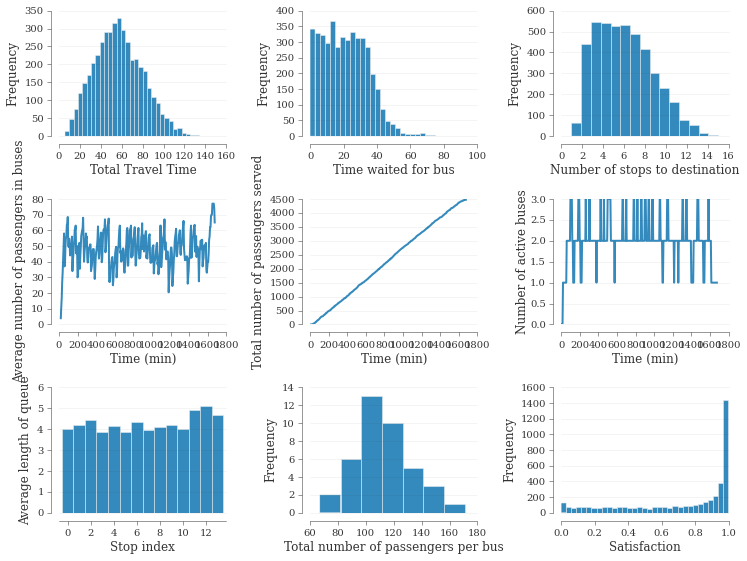

In [87]:
stop_pos = np.arange(0, 30, 2)
nb_stops = len(stop_pos)
mean_stops = nb_stops/2.0
std_stops = nb_stops/4.0
a, b = (1 - mean_stops)/std_stops, (nb_stops - mean_stops)/std_stops
stops_to_dest = lambda: np.round(truncnorm.rvs(a, b, loc=mean_stops, scale=std_stops))
sim = Simulation(bus_stop_positions=stop_pos,
                 time_between_buses=lambda: 40,
                 nb_stops_to_dest=stops_to_dest,
                 passenger_arrival_times=lambda : np.random.exponential(5.0),
                 nb_buses=40)
sim.run()
sim.stats.plot()

In [69]:
print 'Mean satisfaction:', mean(sim.stats.satisfaction)
print 'Mean number of passengers per bus:', mean(sim.stats.total_passengers[-1])

Mean satisfaction: 0.69616130427
Mean number of passengers per bus: 112.125


In [95]:
z = np.random.normal(size=500)

In [99]:
%timeit np.diff(z)

100000 loops, best of 3: 9.81 us per loop


In [100]:
%timeit [b - a for a, b in zip(z[:-1], z[1:])]

1000 loops, best of 3: 428 us per loop


In [110]:
zz = np.random.randint(1, 10, size=500)

In [111]:
%timeit len(np.unique(zz))

10000 loops, best of 3: 22.4 us per loop


In [112]:
%timeit len(set(zz))

10000 loops, best of 3: 71.7 us per loop


In [113]:
len(np.unique(zz)) == len(set(zz))

True

In [119]:
%timeit zz.mean()

100000 loops, best of 3: 15.8 us per loop


In [117]:
%timeit np.mean(zz)

100000 loops, best of 3: 16.1 us per loop
